O objetivo deste exemplo é estimar o consumo de gasolina percorrida (do inglês Miles per Gallon ou MPG) de veículos utilizando algumas características dos carros.

Este é um problema de Regressão, onde se está tentando calcular um valor contínuo, e pertence ao "Aprendizado Supervisionado".

In [1]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Dados**

Os dados utilizados compreendem o clássico conjunto de dados Auto MPG, que possui informações de veículos das décadas de 1970-80.

As características dos veículos incluem: número de cilíndros, cavalos de força, peso, cilidradas, aceleração, ano do modelo, país de origem e o próprio consumo de gasolina (MPG).

In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

32768/30286 [================================] - 0s 1us/step


Definimos o nome das colunas

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Removemos dados desconhecidos ou incompletos:

In [4]:
dataset.isna().sum()
dataset = dataset.dropna()

Em seguinda convertemos os dados da coluna 'Origin', que são textos, para valores numéricos. Assim o algoritmo consegue interpretá-los corretamente, veja:

In [5]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Dividimos os dados em treinamento e teste:

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Podemos visualizar as diferentes características:

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


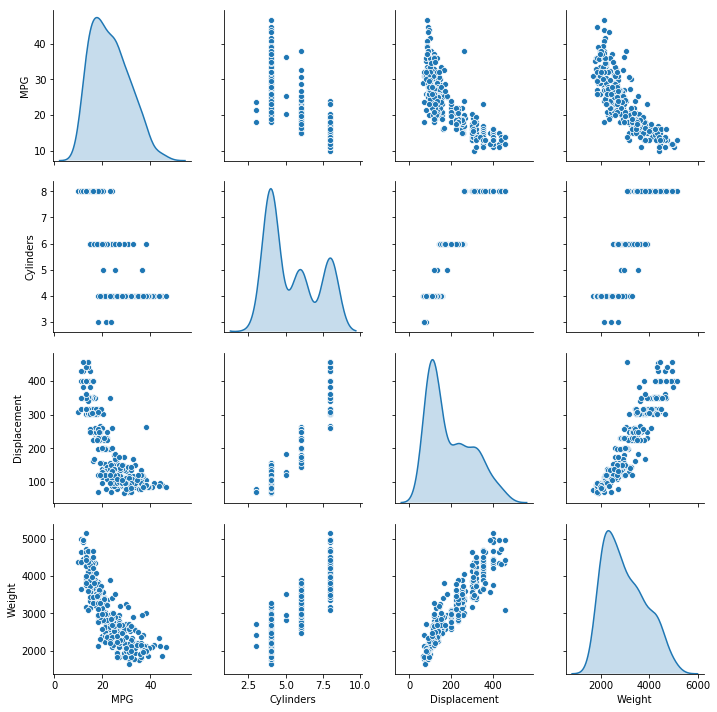

In [7]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

Separa as features das labels:

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [9]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Cria uma função para realizar features scaling (normalizar os dados) para o algoritmo ter uma melhor performance e converger mais rapidamente:

In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

**O modelo**

Nos iremos utilizar um modelo sequential com dois dense hidden layers e um output layer que retorna um único valor contínuo.

É possível colocar a construção do modelo dentro de uma função como é feito a seguir:

In [11]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

**Treinando o modelo**

Treinamos o modelo por 1000 epochs e comparamos os erros (distancia dos dados em relação a média) dos dados estimados pelo algoritmo (Train Error) com o dados para teste (Val Error).

In [12]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

É possível visualizar que depois de um determinado número de epochs o treinamento do algortimo chega um nível estabilizado, onde não há uma melhora em continuar treinando o algoritmo. Isto fica claro ao visualizar os valores de erros *Mean Squared Error* (MSE) e *Mean Absolute Error* (MAE).

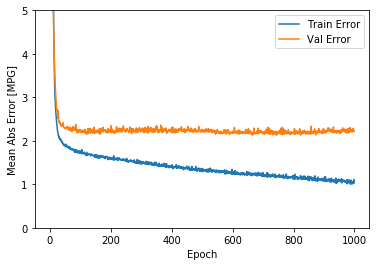

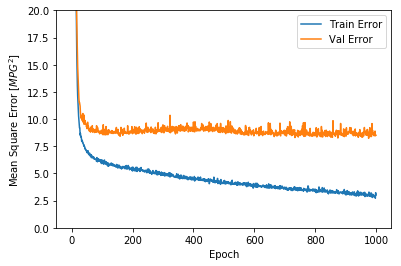

In [13]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Desde modo, é possível inserir no treinamento uma função de EarlyStopping, para parar o treinamento quando o mesmo estabilizar o seu aprendizado.


.........................................................................

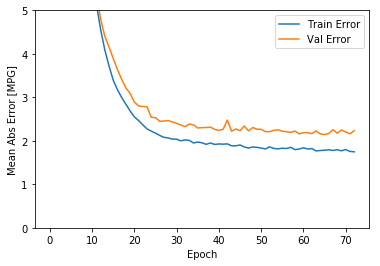

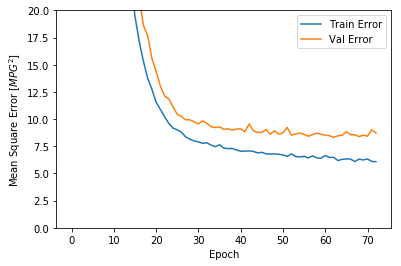

In [14]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

Assim, conseguimos ver que próximo das 100 epochs o modelo já estabiliza e não é necessário continuar treinando por mais epochs.

**Fazendo previsões**

Finalmente, podemos fazer previsões do valor de MPG usando os dados treinados.

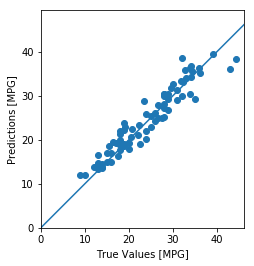

In [15]:
test_predictions = model.predict(normed_test_data).flatten()


plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [16]:
single_prediction = model.predict(normed_test_data[0:1]).flatten()
print(normed_test_data[0:1])
print("MPG => "+str(single_prediction))

   Cylinders  Displacement  Horsepower    ...          USA    Europe     Japan
9   1.483887      1.865988     2.23462    ...     0.774676 -0.465148 -0.495225

[1 rows x 9 columns]
MPG => [17.035067]


**Conclusões**

O gráfico acima relaciona os valores previstos pelo algoritmo para o consumo de "Gasolina por Milha" com o verdadeiros valores gastos pelos carros. É possível visualizar que as estimações do algoritmo são muito próximas da realidade, quase que "espelhadas" com os dados reais.